In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# Load the Excel file into a DataFrame
data = pd.read_excel('INE_IPC.xlsx')



In [2]:
data.rename(columns={
    'Unnamed: 0': 'time',
    '    Índice general': 'index_general',
    '    01 Alimentos y bebidas no alcohólicas': 'food_beverages',
    '    02 Bebidas alcohólicas y tabaco': 'alc_tobacco',
    '    03 Vestido y calzado': 'clothing_footwear',
    '    04 Vivienda, agua, electricidad, gas y otros combustibles': 'housing_utilities',
    '    05 Muebles, artículos del hogar y artículos para el mantenimiento corriente del hogar': 'furniture_household',
    '    06 Sanidad': 'health',
    '    07 Transporte': 'transport',
    '    08 Comunicaciones': 'communications',
    '    09 Ocio y cultura': 'leisure_culture',
    '    10 Enseñanza': 'education',
    '    11 Restaurantes y hoteles': 'restaurants_hotels',
    '    12 Otros bienes y servicios': 'other_goods_services'
}, inplace=True)

data['time'] = pd.to_datetime(data['time'], format='%YM%m')



In [3]:
def plot_inflation(data, inflation_type):
    title = inflation_type
    plt.figure(figsize=(14, 7))

    # Line plot of inflation over time
    plt.subplot(2, 1, 1)
    plt.plot(data['time'], data[inflation_type], marker='o', color='r')
    plt.xlabel('Time')
    plt.ylabel(inflation_type.replace('_', ' ').title())
    plt.title(f'{title} Over Time')
    plt.grid(True)

    # Histogram of inflation
    plt.subplot(2, 1, 2)
    plt.hist(data[inflation_type].dropna(), bins=30, edgecolor='k', color='r')
    plt.xlabel(inflation_type.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {title}')

    plt.tight_layout()
    plt.show()

In [4]:
def plot_acf_pacf(data,variable,lag):
    plt.figure(figsize=(14, 7))
    # Autocorrelation plot
    plt.subplot(2, 1, 1)
    plot_acf(data[variable].dropna(), lags=lag, alpha=0.05, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of {variable.replace("_", " ").title()}')
    plt.grid(True)

    #Partial autocorrelation plot
    plt.subplot(2, 1, 2)
    plot_pacf(data[variable].dropna(), lags=lag, alpha=0.05, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of {variable.replace("_", " ").title()}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [5]:
### Funcions

# plot lineplot and histogram
def plot_eda(data, feature, color='skyblue', transform_func=None):
    plt.figure(figsize=(18, 6))

    # Line plot of the feature over time
    plt.subplot(1, 3, 1)
    plt.plot(data['time'], data[feature], marker='.', color=color)
    plt.xlabel('Time')
    plt.ylabel(feature.replace('_', ' ').title())
    plt.title(f'{feature.replace("_", " ").title()} Over Time')
    plt.grid(True)

    # Histogram of the feature
    plt.subplot(1, 3, 2)
    plt.hist(data[feature].dropna(), bins=30, edgecolor='k', color=color, density=True)

    mean = data[feature].mean()
    std = data[feature].std()
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    p = np.exp(-0.5 * ((x - mean) / std)**2) / (std * np.sqrt(2 * np.pi))

    plt.plot(x, p, color='red', linewidth=2)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Density')
    plt.title(f'Histogram + Normal Dist of {feature.replace("_", " ").title()}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# plot lineplot and histogram
def plot_eda2(data, feature, color='skyblue', transform_func=None):
    plt.figure(figsize=(24, 6))  # Adjusted for a single row layout
    
    # Line plot of the feature over time
    plt.subplot(1, 4, 1)
    plt.plot(data['time'], data[feature], marker='.', color=color)
    plt.xlabel('Time')
    plt.ylabel(feature.replace('_', ' ').title())
    plt.title(f'{feature.replace("_", " ").title()} Over Time')
    plt.grid(True)
    
    # Histogram of the feature
    plt.subplot(1, 4, 2)
    plt.hist(data[feature].dropna(), bins=30, edgecolor='k', color=color, density=True)
    mean = data[feature].mean()
    std = data[feature].std()
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    p = np.exp(-0.5 * ((x - mean) / std)**2) / (std * np.sqrt(2 * np.pi))
    plt.plot(x, p, color='red', linewidth=2)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Density')
    plt.title(f'Histogram + Normal Dist of {feature.replace("_", " ").title()}')
    plt.grid(True)
    
    # Autocorrelation plot
    plt.subplot(1, 4, 3)
    plot_acf(data[feature].dropna(), lags=40, alpha=0.05, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation of {feature.replace("_", " ").title()}')
    plt.grid(True)
    
    # Partial Autocorrelation plot
    plt.subplot(1, 4, 4)
    plot_pacf(data[feature].dropna(), lags=40, alpha=0.05, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.title(f'Partial Autocorrelation of {feature.replace("_", " ").title()}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



## Original Data General index

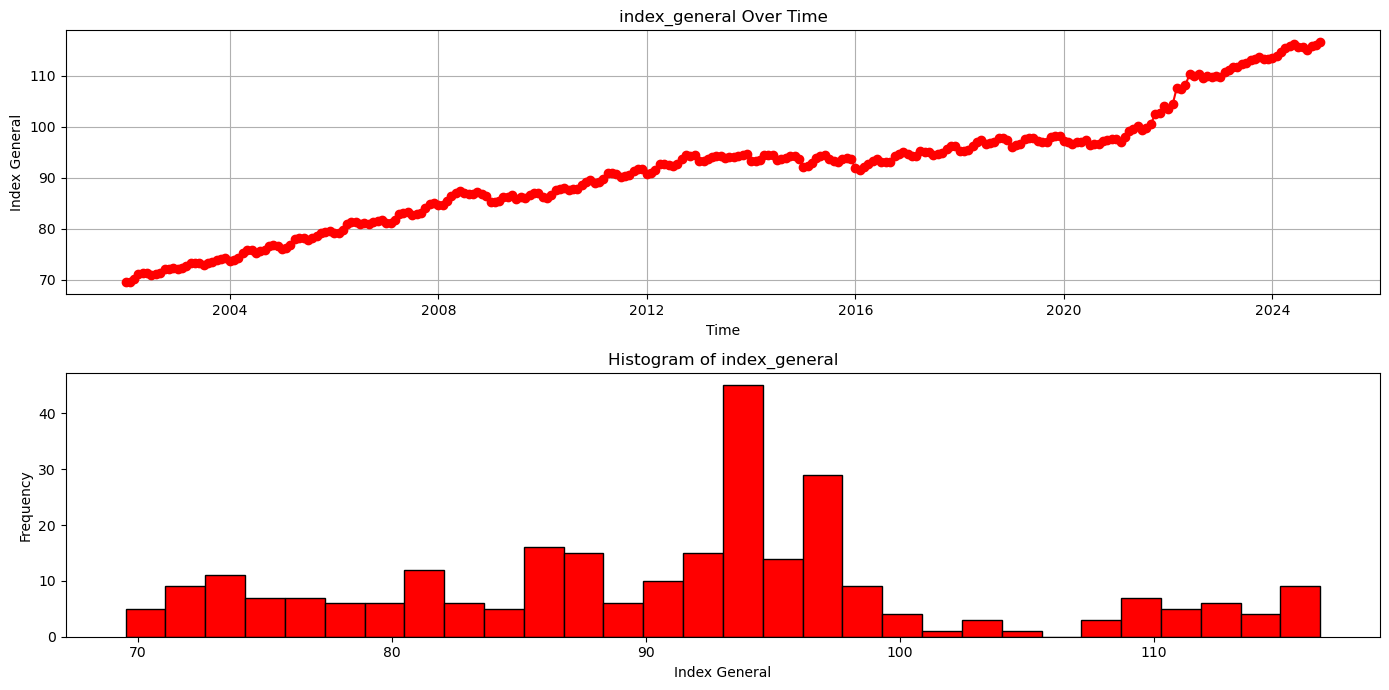

In [6]:
plot_inflation(data,"index_general")

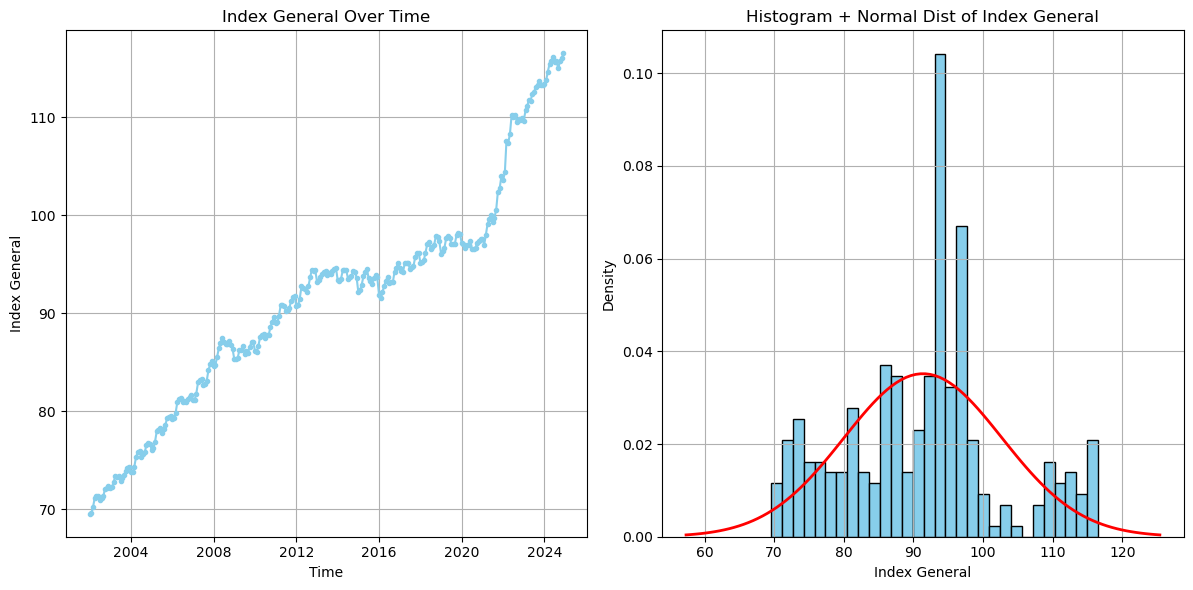

In [7]:
plot_eda(data,"index_general")

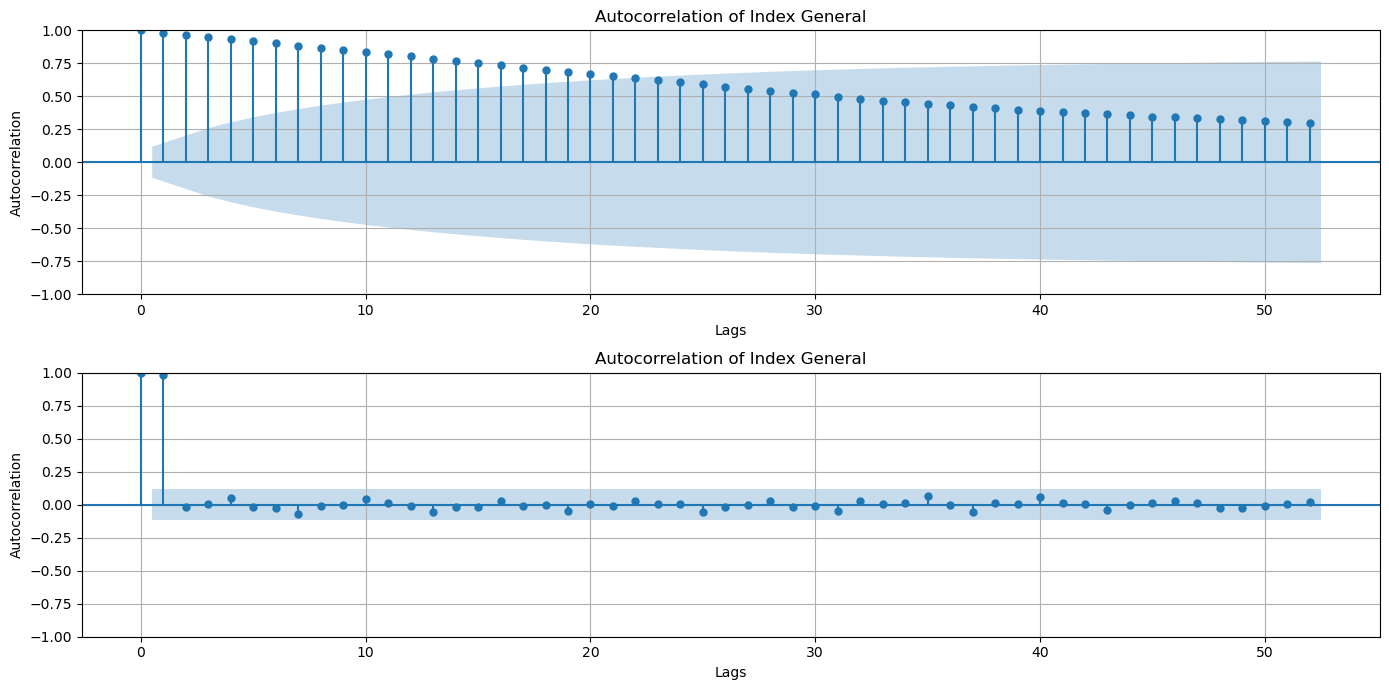

In [8]:
plot_acf_pacf(data,"index_general",52)

## Monthly inflation

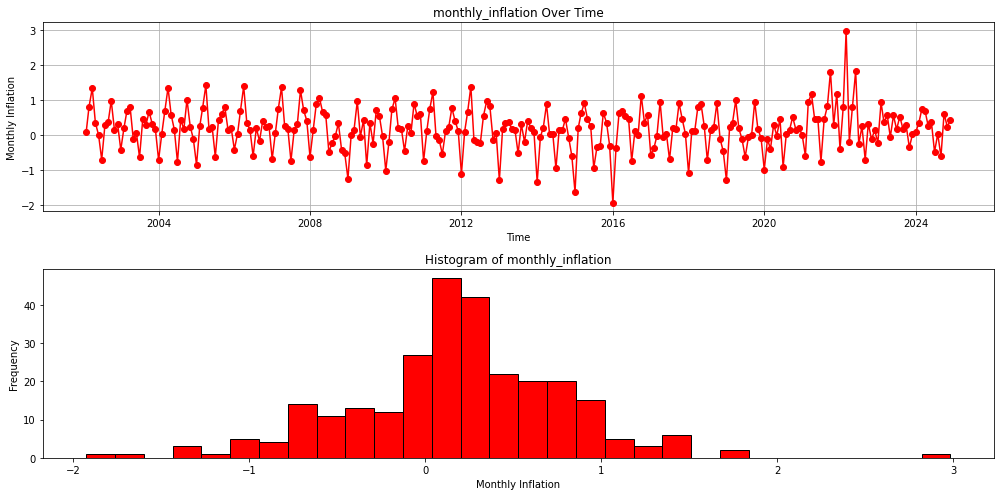

In [9]:
# Calculate the monthly inflation
data['monthly_inflation'] = 100 * (np.log(data['index_general']) - np.log(data['index_general'].shift(1)))

# Drop the first row as it will have NaN value for monthly_inflation
data.dropna(subset=['monthly_inflation'], inplace=True)

plot_inflation(data, 'monthly_inflation')


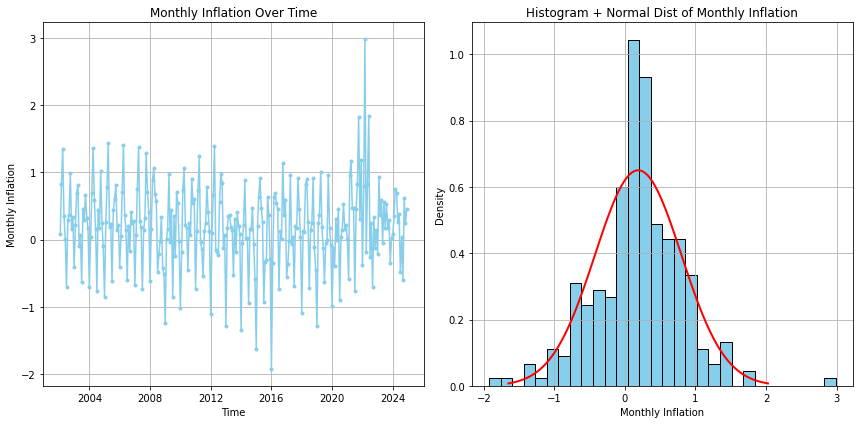

In [10]:
plot_eda(data,"monthly_inflation")

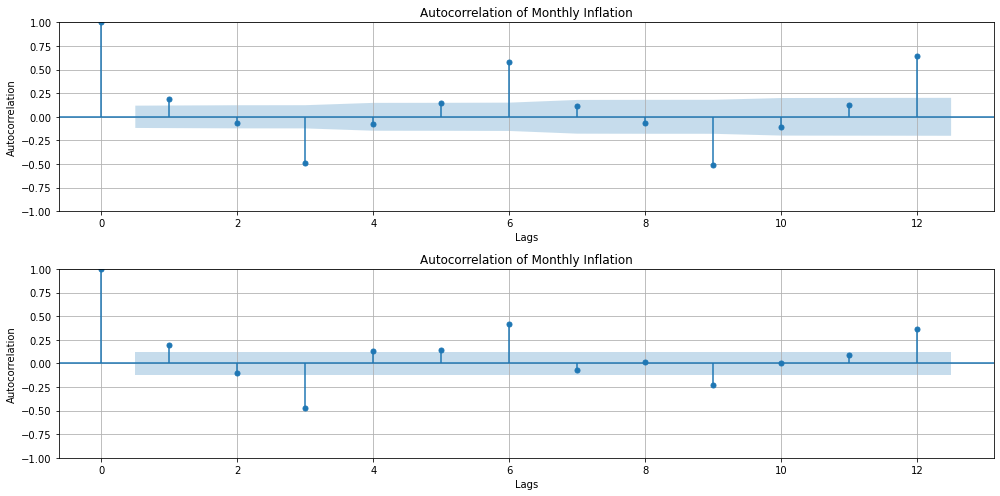

In [11]:
plot_acf_pacf(data,"monthly_inflation",12)

In [12]:
# Perform the Dickey-Fuller test
result = adfuller(data['monthly_inflation'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.3858981155284003
p-value: 0.011449101151194364


## Yearly inflation

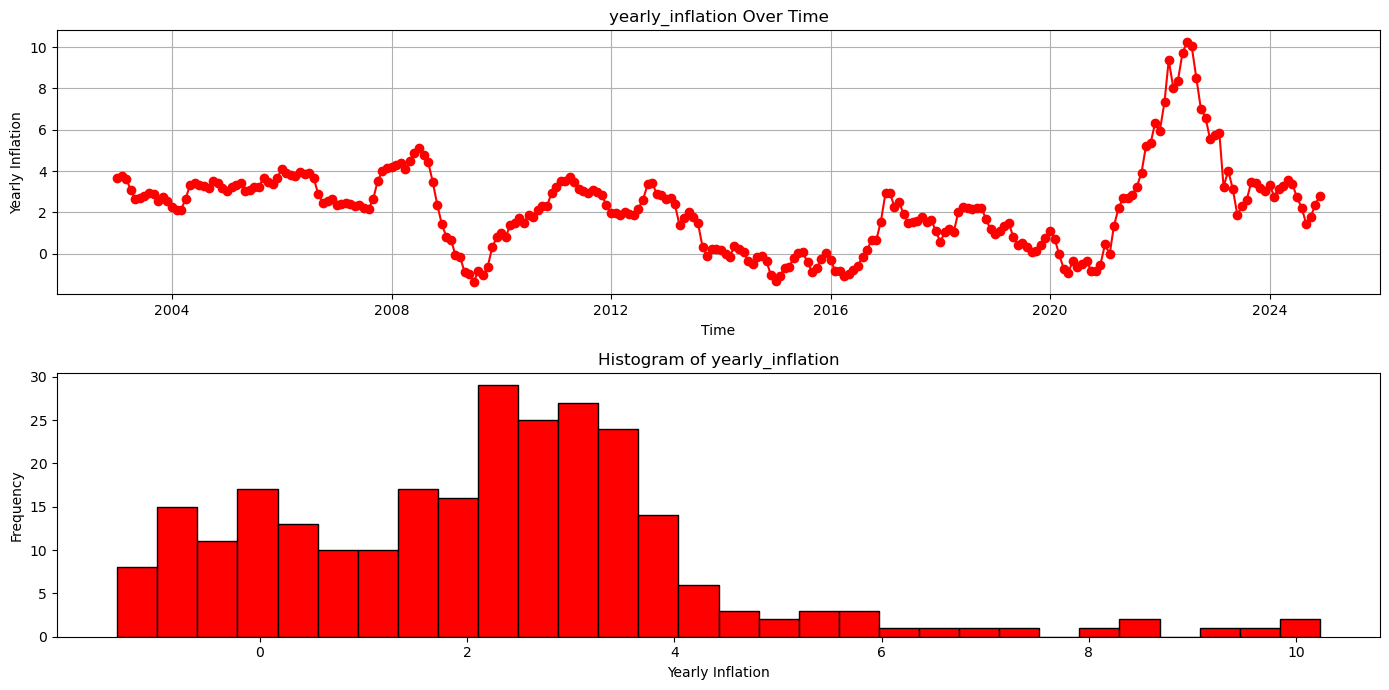

In [13]:
### Check seasonality patterns

# Calculate the monthly inflation
data['yearly_inflation'] = 100 * (np.log(data['index_general']) - np.log(data['index_general'].shift(12)))

# Drop the first row as it will have NaN value for monthly_inflation
data.dropna(subset=['yearly_inflation'], inplace=True)

plot_inflation(data, 'yearly_inflation')

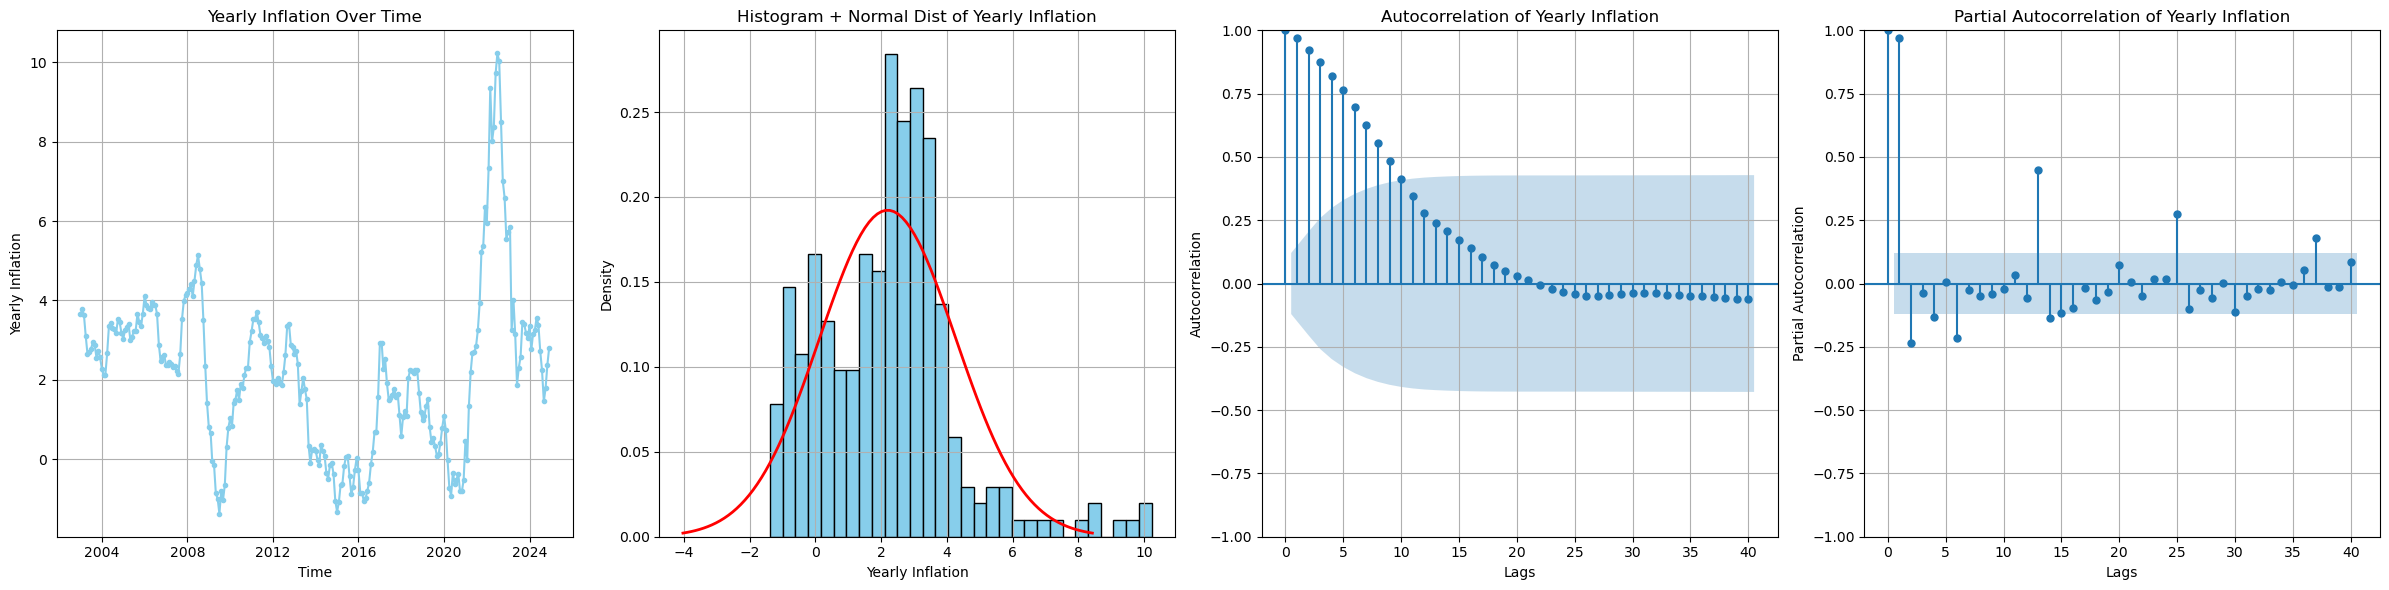

In [14]:
plot_eda2(data,"yearly_inflation")

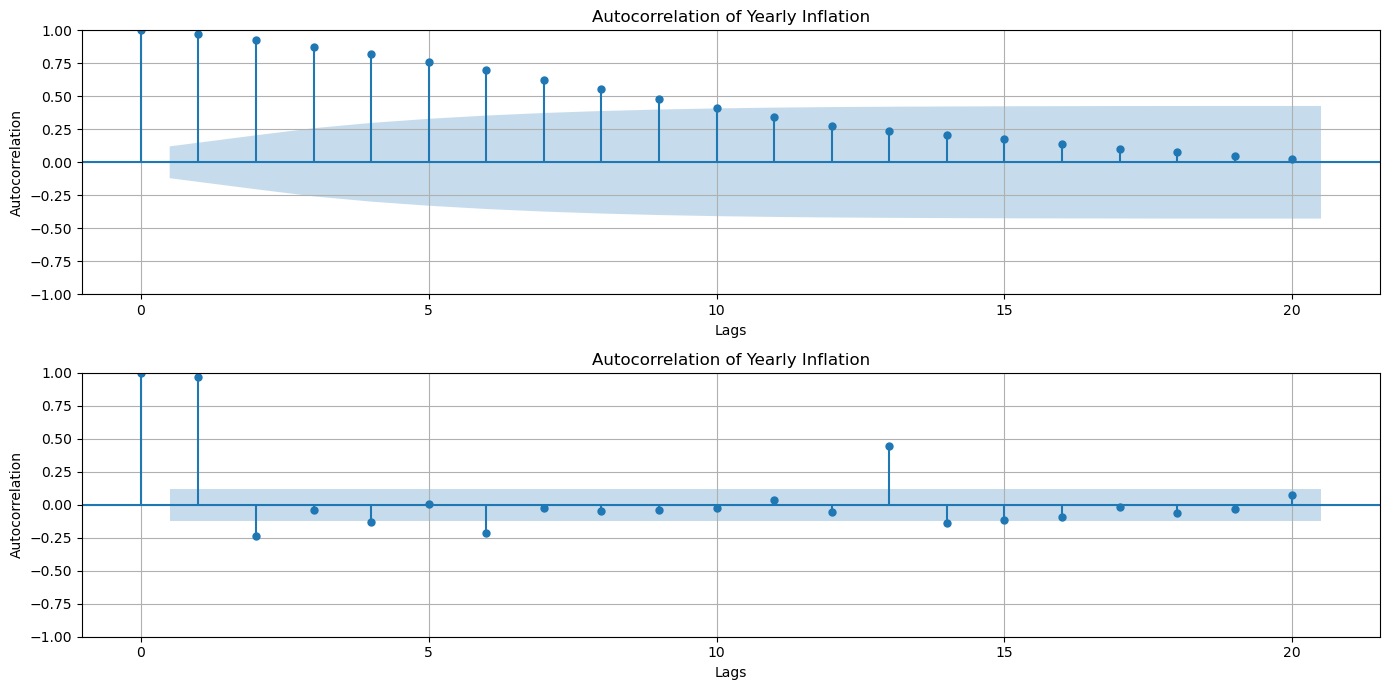

In [15]:
plot_acf_pacf(data,"yearly_inflation",20)

In [16]:
# Perform the Dickey-Fuller test
result = adfuller(data['yearly_inflation'])

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Perform the Dickey-Fuller test
result = adfuller(data['yearly_inflation'].diff().dropna())

# Extract and print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.853114475307455
p-value: 0.051078118868269864
ADF Statistic: -4.263011222542817
p-value: 0.0005144930515842021


# Models

AR(1)

In [17]:
def ar_test_model(data, feature, p=1, dif=0 ,q=0):
    # Fit the ARIMA model
    model = ARIMA(data[feature], order=(p, dif, q))
    model_fit = model.fit()
    
    print(model_fit.summary())
    
    # Plot diagnostics in a single row
    fig = model_fit.plot_diagnostics(figsize=(20, 5))
    
    for i, ax in enumerate(fig.axes):
        ax.set_position([0.05 + i * 0.27, 0.15, 0.23, 0.75])  # Adjust subplot positions
    
    plt.show()
    
    return model_fit



                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -195.672
Date:                Tue, 11 Mar 2025   AIC                            397.343
Time:                        10:18:12   BIC                            408.060
Sample:                             0   HQIC                           401.650
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3860      0.981      2.433      0.015       0.464       4.308
ar.L1          0.9674      0.010     94.429      0.000       0.947       0.987
sigma2         0.2556      0.013     19.070      0.0

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


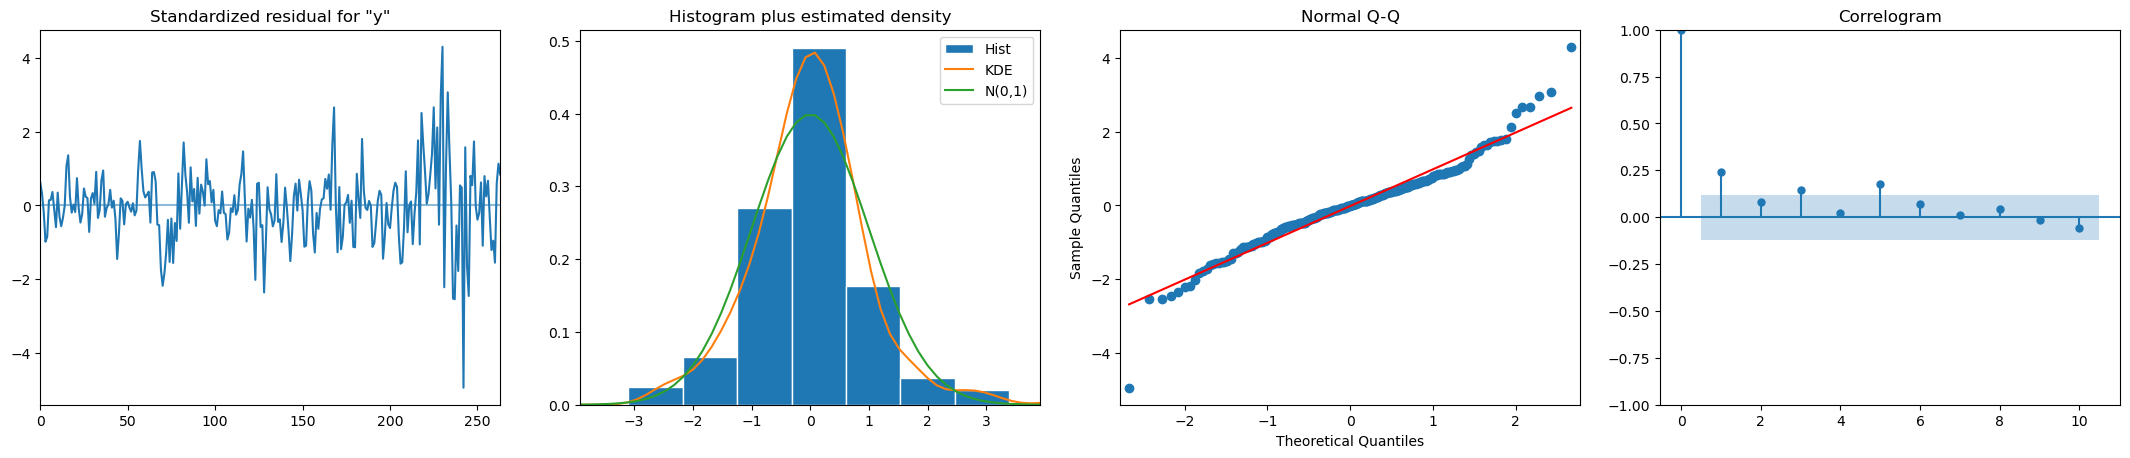

In [18]:
model_ar_1 = ar_test_model(data,"yearly_inflation",p=1)

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -187.595
Date:                Tue, 11 Mar 2025   AIC                            383.190
Time:                        10:18:12   BIC                            397.479
Sample:                             0   HQIC                           388.933
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3310      0.815      2.861      0.004       0.734       3.928
ar.L1          1.2042      0.035     34.184      0.000       1.135       1.273
ar.L2         -0.2436      0.037     -6.649      0.0

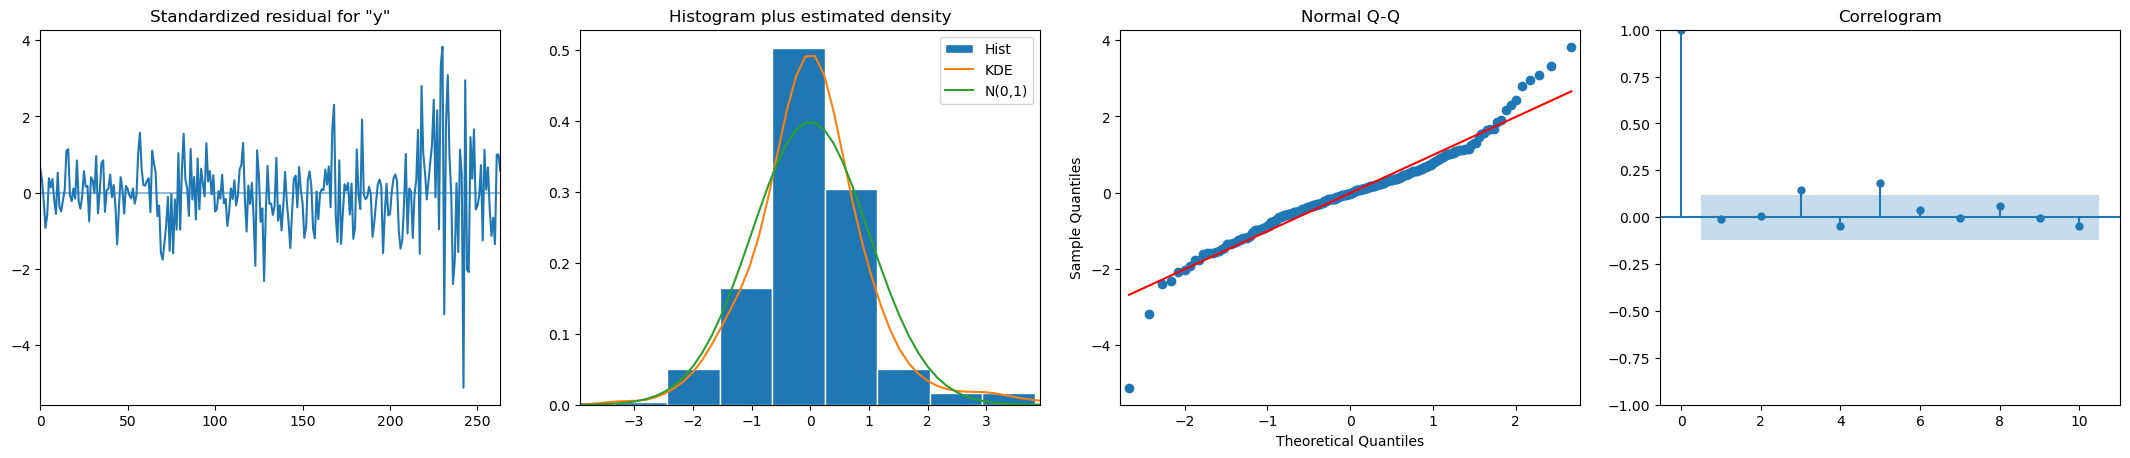

In [19]:
model_ar_2 = ar_test_model(data,"yearly_inflation",p=2)

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -187.309
Date:                Tue, 11 Mar 2025   AIC                            384.618
Time:                        10:18:13   BIC                            402.479
Sample:                             0   HQIC                           391.796
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3247      0.786      2.959      0.003       0.785       3.865
ar.L1          1.1931      0.035     33.917      0.000       1.124       1.262
ar.L2         -0.1884      0.056     -3.353      0.0

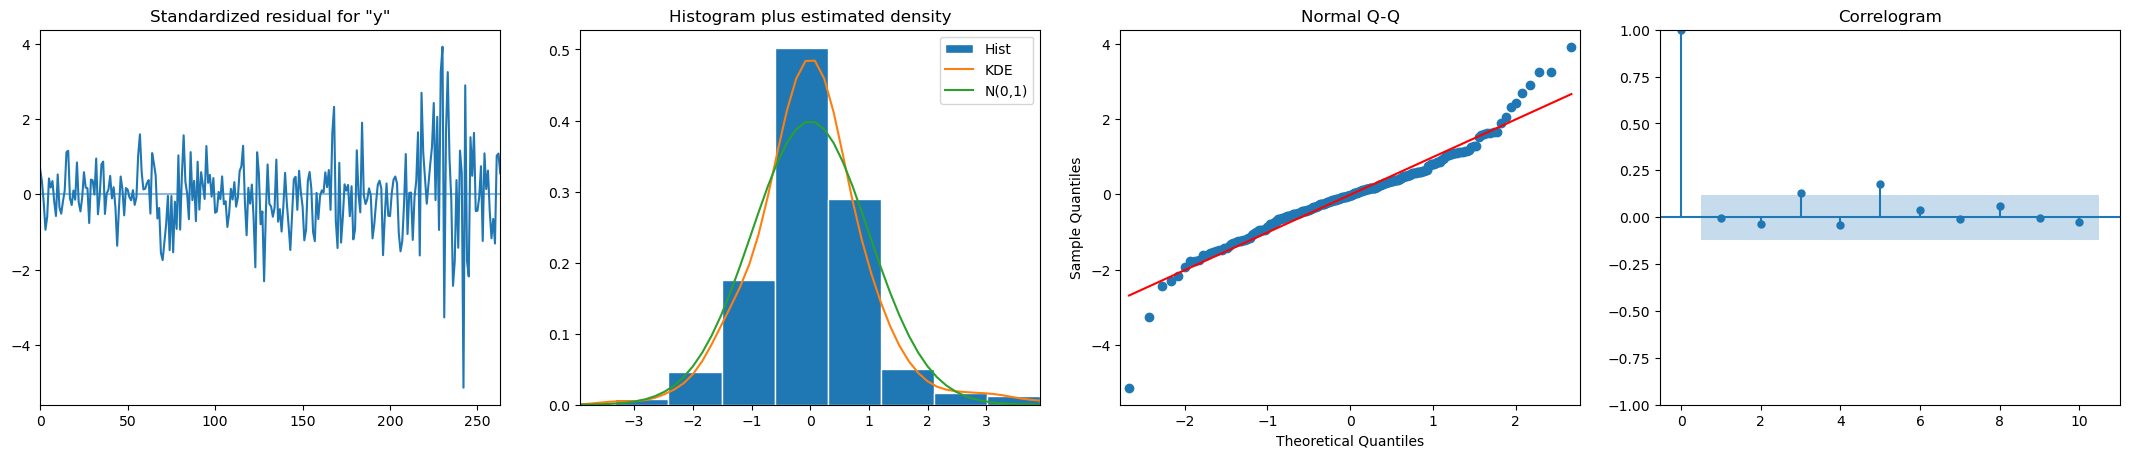

In [20]:
ar_test_model(data,"yearly_inflation",p =3)

In [21]:
from pmdarima import auto_arima

auto_model = auto_arima(data["yearly_inflation"], seasonal=False, trace=True, stepwise=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=386.465, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1329.540, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=399.160, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=389.005, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=385.866, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=387.057, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=386.337, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=388.059, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=379.182, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=384.318, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=383.190, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 s

                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  264
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -175.136
Date:                Tue, 11 Mar 2025   AIC                            360.272
Time:                        22:03:16   BIC                            378.133
Sample:                             0   HQIC                           367.450
                                - 264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0182      0.148     -0.123      0.902      -0.309       0.272
ar.L2          0.5834      0.097      6.008      0.000       0.393       0.774
ma.L1          0.3628      0.550      0.660      0.5

c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\flore\anaconda3\envs\pyomo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       yearly_inflation   No. Observations:                  263
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -195.672
Date:                Tue, 11 Mar 2025   AIC                            397.343
Time:                        17:33:06   BIC                            408.060
Sample:                             0   HQIC                           401.650
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3991      0.980      2.448      0.014       0.478       4.320
ar.L1          0.9676      0.010     94.080      0.000       0.947       0.988
sigma2         0.2566      0.014     18.995      0.0

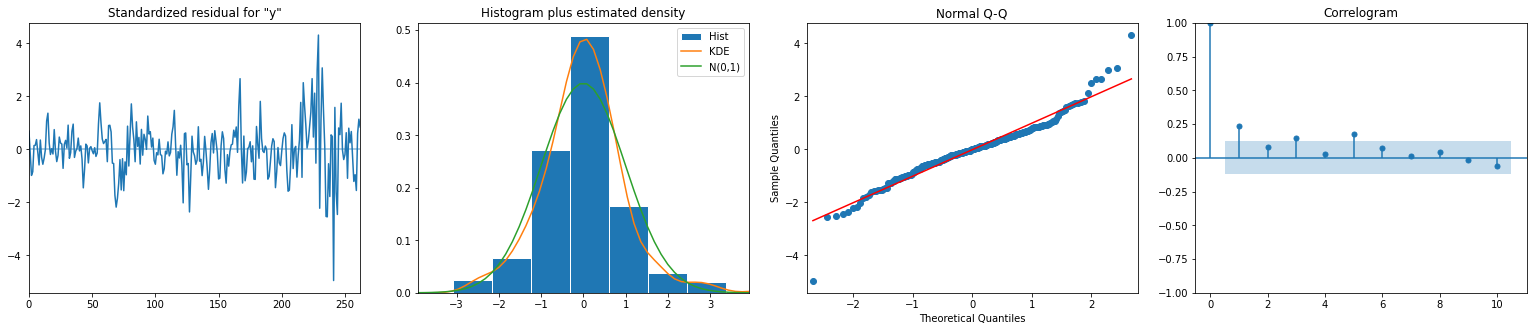

In [90]:
ar_test_model(data,"yearly_inflation",p=1,dif=0,q=0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

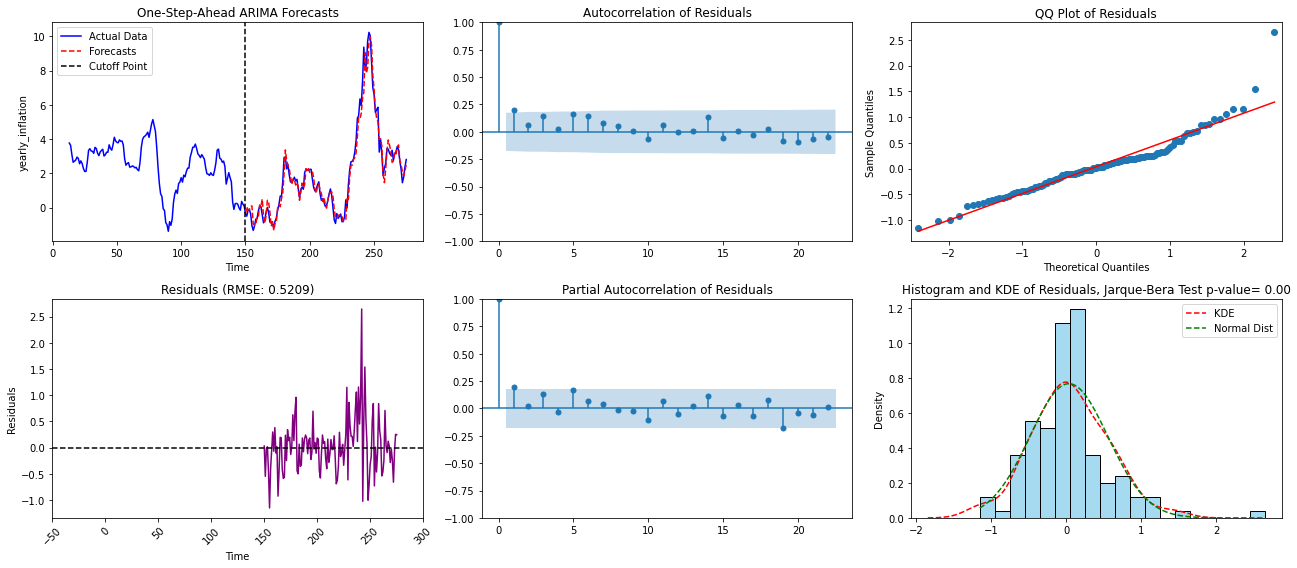

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
import seaborn as sns

def one_step_ahead_forecast(data, 
                            feature, 
                            order,
                            cutoff,
                            seasonal_order,
                            plot_bool = True):

    forecasts = []
    history = data[feature].loc[:cutoff].tolist()
    history_empty = []
    future_index = data.loc[cutoff:].index
    
    residuals = []
    
    for t in range(len(future_index)):
        model = ARIMA(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]  # One-step-ahead forecast
        forecasts.append(forecast)
        actual_value = data[feature].loc[future_index[t]]
        history.append(actual_value)  # Append actual value
        history_empty.append(actual_value)
        residuals.append(actual_value - forecast)
    
    forecast_series = pd.Series(forecasts, index=future_index)
    residuals_series = pd.Series(residuals, index=future_index)

    # Create a DataFrame from forecast_series and residuals_series
    forecast_residuals_df = pd.DataFrame({
        'Forecast': forecast_series,
        'True Value': history_empty,
        'Residuals': residuals_series
    })

    # Compute RMSE from residuals_series
    rmse = np.sqrt(np.mean(residuals_series**2))
    
    if plot_bool:
        # Plot the results
        fig, axes = plt.subplots(2, 3, figsize=(18, 8))
        
        # Forecast plot
        axes[0, 0].plot(data[feature], label="Actual Data", color="blue")
        axes[0, 0].plot(forecast_series, label="Forecasts", color="red", linestyle="dashed")
        axes[0, 0].axvline(x=cutoff, color="black", linestyle="--", label="Cutoff Point")
        axes[0, 0].legend()
        axes[0, 0].set_title("One-Step-Ahead ARIMA Forecasts")
        axes[0, 0].set_xlabel("Time")
        axes[0, 0].set_ylabel(feature)
        
        # Residuals plot
        axes[1, 0].plot(residuals_series, color="purple")
        axes[1, 0].axhline(y=0, color='black', linestyle='--')
        axes[1, 0].set_title(f"Residuals (RMSE: {rmse:.4f})")
        axes[1, 0].set_xlabel("Time")
        axes[1, 0].set_ylabel("Residuals")
        axes[1, 0].set_xticks(axes[0, 0].get_xticks())  # Align x ticks
        axes[1, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
        
        # ACF plot
        sm.graphics.tsa.plot_acf(residuals_series, ax=axes[0, 1])
        axes[0, 1].set_title("Autocorrelation of Residuals")
        
        # PACF plot
        sm.graphics.tsa.plot_pacf(residuals_series, ax=axes[1, 1])
        axes[1, 1].set_title("Partial Autocorrelation of Residuals")
        
        # Residual normality plot
        jb_test = sm.stats.jarque_bera(residuals_series)

        sm.qqplot(residuals_series, line='s', ax=axes[0, 2])
        axes[0, 2].set_title("QQ Plot of Residuals")
        
        # Histogram and KDE of residuals
        sns.histplot(residuals_series, kde=False, ax=axes[1, 2], stat="density", color="skyblue")
        sns.kdeplot(np.random.normal(np.mean(residuals_series), np.std(residuals_series), len(residuals_series)), ax=axes[1, 2], color="red", linestyle="--", label="KDE")
        sample_mean = np.mean(residuals_series)
        sample_var = np.var(residuals_series)
        x = np.linspace(min(residuals_series), max(residuals_series), 100)
        y = (1 / (np.sqrt(2 * np.pi * sample_var))) * np.exp(-0.5 * ((x - sample_mean) ** 2 / sample_var))
        axes[1, 2].plot(x, y, color="green", linestyle="--", label="Normal Dist")

        axes[1, 2].set_title(f"Histogram and KDE of Residuals, Jarque-Bera Test p-value= {jb_test[1]:.2f}")
        
        
        axes[1, 2].legend()

        plt.tight_layout()
        plt.show()
    
    return forecast_residuals_df


forecast_residuals_df = one_step_ahead_forecast(data = data, 
                                                feature = "yearly_inflation", 
                                                order = (1,0,0), 
                                                cutoff=data.index[data.index.get_loc(150)],
                                                seasonal_order=(0,0,1,12)
)

# Nico: ARMA 5,12





In [54]:
from itertools import product

def grid_search_one_step_ahead_forecast(data, feature, cutoff, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    best_rmse = float('inf')
    best_order = None
    best_seasonal_order = None
    best_forecast_residuals_df = None

    for order in product(p_values, d_values, q_values):
        for seasonal_order in product(P_values, D_values, Q_values, m_values):
            try:
                forecast_residuals_df = one_step_ahead_forecast(data, feature, order, cutoff, seasonal_order,plot_bool=False)
                rmse = np.sqrt(np.mean(forecast_residuals_df['Residuals']**2))
                print(f'Order: {order}, Seasonal Order: {seasonal_order}, RMSE: {rmse:.4f}')
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_forecast_residuals_df = forecast_residuals_df
            except Exception as e:
                print(f'Error with order {order} and seasonal order {seasonal_order}: {e}')
                continue

    print(f'Best Order: {best_order}, Best Seasonal Order: {best_seasonal_order}, Best RMSE: {best_rmse:.4f}')
    return best_order, best_seasonal_order, best_forecast_residuals_df

# Define the range of parameters to search
p_values = [1, 2]
d_values = [0, 1]
q_values = [0, 1]
P_values = [0, 1]
D_values = [0, 1]
Q_values = [0, 1]
m_values = [6]

# Perform grid search
best_order, best_seasonal_order, best_forecast_residuals_df = grid_search_one_step_ahead_forecast(
    data=data,
    feature='monthly_inflation',
    cutoff=data.index[data.index.get_loc(250)],
    p_values=p_values,
    d_values=d_values,
    q_values=q_values,
    P_values=P_values,
    D_values=D_values,
    Q_values=Q_values,
    m_values=m_values
)

Order: (1, 0, 0), Seasonal Order: (0, 0, 0, 6), RMSE: 0.3832
Order: (1, 0, 0), Seasonal Order: (0, 0, 1, 6), RMSE: 0.4695
Order: (1, 0, 0), Seasonal Order: (0, 1, 0, 6), RMSE: 0.6664


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (1, 0, 0), Seasonal Order: (0, 1, 1, 6), RMSE: 0.5910
Order: (1, 0, 0), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5117
Order: (1, 0, 0), Seasonal Order: (1, 0, 1, 6), RMSE: 0.5662
Order: (1, 0, 0), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6118
Order: (1, 0, 0), Seasonal Order: (1, 1, 1, 6), RMSE: 0.5906


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (1, 0, 1), Seasonal Order: (0, 0, 0, 6), RMSE: 0.3908
Order: (1, 0, 1), Seasonal Order: (0, 0, 1, 6), RMSE: 0.4772
Order: (1, 0, 1), Seasonal Order: (0, 1, 0, 6), RMSE: 0.6555
Order: (1, 0, 1), Seasonal Order: (0, 1, 1, 6), RMSE: 0.5964
Order: (1, 0, 1), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5127


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (1, 0, 1), Seasonal Order: (1, 0, 1, 6), RMSE: 0.5568
Order: (1, 0, 1), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6131
Order: (1, 0, 1), Seasonal Order: (1, 1, 1, 6), RMSE: 0.5977
Order: (1, 1, 0), Seasonal Order: (0, 0, 0, 6), RMSE: 0.4304
Order: (1, 1, 0), Seasonal Order: (0, 0, 1, 6), RMSE: 0.5194
Order: (1, 1, 0), Seasonal Order: (0, 1, 0, 6), RMSE: 0.7477


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Order: (1, 1, 0), Seasonal Order: (0, 1, 1, 6), RMSE: 0.6753
Order: (1, 1, 0), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5733
Order: (1, 1, 0), Seasonal Order: (1, 0, 1, 6), RMSE: 0.6521


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (1, 1, 0), Seasonal Order: (1, 1, 0, 6), RMSE: 0.7180
Order: (1, 1, 0), Seasonal Order: (1, 1, 1, 6), RMSE: 0.6884
Order: (1, 1, 1), Seasonal Order: (0, 0, 0, 6), RMSE: 0.3835


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (1, 1, 1), Seasonal Order: (0, 0, 1, 6), RMSE: 0.4703
Order: (1, 1, 1), Seasonal Order: (0, 1, 0, 6), RMSE: 0.6677
Order: (1, 1, 1), Seasonal Order: (0, 1, 1, 6), RMSE: 0.6115
Order: (1, 1, 1), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5137


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Order: (1, 1, 1), Seasonal Order: (1, 0, 1, 6), RMSE: 0.5530


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (1, 1, 1), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6140
Order: (1, 1, 1), Seasonal Order: (1, 1, 1, 6), RMSE: 0.6333
Order: (2, 0, 0), Seasonal Order: (0, 0, 0, 6), RMSE: 0.4001
Order: (2, 0, 0), Seasonal Order: (0, 0, 1, 6), RMSE: 0.4789
Order: (2, 0, 0), Seasonal Order: (0, 1, 0, 6), RMSE: 0.6647
Order: (2, 0, 0), Seasonal Order: (0, 1, 1, 6), RMSE: 0.5832
Order: (2, 0, 0), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5136
Order: (2, 0, 0), Seasonal Order: (1, 0, 1, 6), RMSE: 0.5602
Order: (2, 0, 0), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6132


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 0, 0), Seasonal Order: (1, 1, 1, 6), RMSE: 0.5838


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (2, 0, 1), Seasonal Order: (0, 0, 0, 6), RMSE: 0.3982
Order: (2, 0, 1), Seasonal Order: (0, 0, 1, 6), RMSE: 0.4724
Order: (2, 0, 1), Seasonal Order: (0, 1, 0, 6), RMSE: 0.6530
Order: (2, 0, 1), Seasonal Order: (0, 1, 1, 6), RMSE: 0.6048


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Order: (2, 0, 1), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5150


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Order: (2, 0, 1), Seasonal Order: (1, 0, 1, 6), RMSE: 0.5827


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 0, 1), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6493
Order: (2, 0, 1), Seasonal Order: (1, 1, 1, 6), RMSE: 0.6073
Order: (2, 1, 0), Seasonal Order: (0, 0, 0, 6), RMSE: 0.4342
Order: (2, 1, 0), Seasonal Order: (0, 0, 1, 6), RMSE: 0.5390
Order: (2, 1, 0), Seasonal Order: (0, 1, 0, 6), RMSE: 0.7467
Order: (2, 1, 0), Seasonal Order: (0, 1, 1, 6), RMSE: 0.7487
Order: (2, 1, 0), Seasonal Order: (1, 0, 0, 6), RMSE: 0.6072
Order: (2, 1, 0), Seasonal Order: (1, 0, 1, 6), RMSE: 0.7223


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 1, 0), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6735
Order: (2, 1, 0), Seasonal Order: (1, 1, 1, 6), RMSE: 0.7510
Order: (2, 1, 1), Seasonal Order: (0, 0, 0, 6), RMSE: 0.4040


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 1, 1), Seasonal Order: (0, 0, 1, 6), RMSE: 0.4791
Order: (2, 1, 1), Seasonal Order: (0, 1, 0, 6), RMSE: 0.6654


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 1, 1), Seasonal Order: (0, 1, 1, 6), RMSE: 0.6049


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 1, 1), Seasonal Order: (1, 0, 0, 6), RMSE: 0.5151


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Order: (2, 1, 1), Seasonal Order: (1, 0, 1, 6), RMSE: 0.5541


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 1, 1), Seasonal Order: (1, 1, 0, 6), RMSE: 0.6430


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 1, 1), Seasonal Order: (1, 1, 1, 6), RMSE: 0.6320
Best Order: (1, 0, 0), Best Seasonal Order: (0, 0, 0, 6), Best RMSE: 0.3832


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.

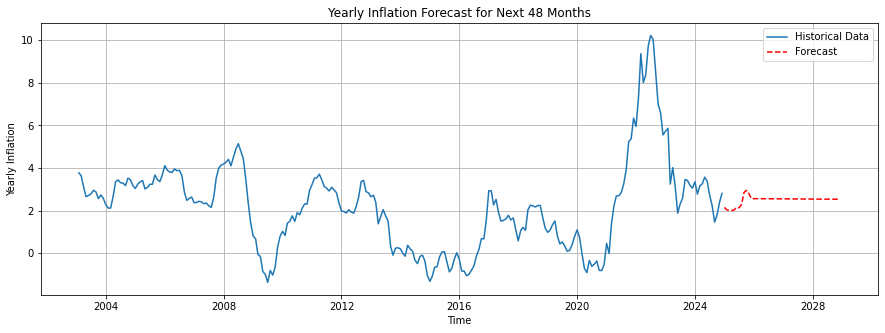

,yearly_inflation
2025-01-01,2.145188
2025-02-01,2.023051
2025-03-01,2.019925
2025-04-01,2.001018
2025-05-01,2.028018
2025-06-01,2.149382
2025-07-01,2.125852
2025-08-01,2.286636
2025-09-01,2.849904
2025-10-01,2.949848


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

def predict_next_12_months(data, feature, order,future_steps=12):
    """
    Predicts the next 12 months using an ARIMA model and plots the results.
    
    Parameters:
    - data: DataFrame containing the time series data.
    - feature: The column name of the feature to model.
    - order: Tuple (p, d, q) specifying the ARIMA order.
    
    Returns:
    - A DataFrame containing the original data and the predictions.
    """
    # Ensure time column is datetime format
    data = data.copy()
    data['time'] = pd.to_datetime(data['time'])
    data.set_index('time', inplace=True)

    # Drop missing values
    data = data[[feature]].dropna()

    # Fit the ARIMA model
    model = ARIMA(data[feature], order=(1, 0, 0),seasonal_order=(0,0,1,12))
    model_fit = model.fit()
    
    # Forecast the next 12 months
    forecast = model_fit.forecast(steps=future_steps, typ='levels')

    # Create a DataFrame for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')
    forecast_df = pd.DataFrame({feature: forecast}, index=forecast_index)

    # Plot the results
    plt.figure(figsize=(15, 5))
    plt.plot(data.index, data[feature], label='Historical Data')
    plt.plot(forecast_df.index, forecast_df[feature], label='Forecast', color='red', linestyle='dashed')
    plt.xlabel('Time')
    plt.ylabel(feature.replace('_', ' ').title())
    plt.title(f'{feature.replace("_", " ").title()} Forecast for Next {future_steps} Months')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return forecast_df

# Example usage
forecast_df = predict_next_12_months(data, 'yearly_inflation', order=(1, 0, 0),future_steps=48)
forecast_df


In [25]:
forecast_df

,yearly_inflation
2025-01-01,2.862610
2025-02-01,2.899191
2025-03-01,2.919460
2025-04-01,2.925697
2025-05-01,2.920056
2025-06-01,2.904542
2025-07-01,2.881009
2025-08-01,2.851148
2025-09-01,2.816483
2025-10-01,2.778378
